# Mosaic

Exploration of mosaicking.

# Imports

In [1]:
# Native python
import copy
import os

In [2]:
# External
import cv2
import numpy as np
from osgeo import gdal
import pandas as pd
import sklearn.model_selection
import tqdm
import pyproj

In [3]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('white')
import folium

In [4]:
# Custom scripts
from nitelite_mapmaker import mapmaker, georeference, observations

# Settings

In [5]:
settings = dict(
    # Data architecture
    flight_name = '220513-FH135',
    data_dir = '/Users/Shared/data/nitelite',
    google_drive_dir = '/Users/zhafensaavedra/Google Drive/Shared drives/NITELite/Data & Analysis',
    flight_subdir = 'Old NITELite Flights/220513-FH135',
    reffed_subdir = 'QGIS FH135/FH135 Main Project/Main Geo Files',
    img_log_filename = 'image.log',
    imu_log_filename = 'OBC/PresIMULog.csv',
    gps_log_filename = 'OBC/GPSLog.csv',
      
    # Choices for what to process
    camera_num = 1,
    test_size = 0.2,
    overwrite_coords_for_reffed = True,
    random_state = 165741,
    
    # Data filter choices
    # gyro_mag_cut = 0.5, # Corresponds to ~84th percentile
    gyro_mag_cut = 0.02, # Based on visual inspection
    # percent_for_landed = 95.,
    percent_for_cruising = 85.,
    # mult_of_std_for_steady = 2.,
    # rolling_window_in_min = 1.,
    homography_det_min = 0.5, # Only let the image shrink or scale by up to a factor of 2
    
    # Mosaicking choices
    allotted_memory = 2., # In GB
    n_tiles_guess = 16,
)

# Set Up

## Settings Parsing

In [6]:
# The camera has an according long number
settings['camera_long_num'] = settings['camera_num'] + 23085686

In [7]:
# Data architecture processing
settings['image_dir'] = os.path.join(
    settings['data_dir'],
    'images',
    settings['flight_name'],
    str(settings['camera_long_num'])
)
settings['metadata_dir'] = os.path.join(
    settings['google_drive_dir'],
    settings['flight_subdir'],
    'data',
)
settings['referenced_dir'] = os.path.join(
    settings['google_drive_dir'],
    settings['reffed_subdir'],
)

## Object Creation and Preprocessing

In [8]:
# Create the main mapmaker object
mm = mapmaker.Mapmaker(
    image_dir=settings['image_dir'],
    img_log_fp=os.path.join(settings['metadata_dir'], settings['img_log_filename']),
    imu_log_fp=os.path.join(settings['metadata_dir'], settings['imu_log_filename']),
    gps_log_fp=os.path.join(settings['metadata_dir'], settings['gps_log_filename']),
    referenced_dir=settings['referenced_dir']
)

In [9]:
# General metadata loading
mm.prep()

In [10]:
mm.flight.update_metadata_with_cart_bounds()

In [11]:
metadata = mm.flight.metadata
referenced = metadata.loc[metadata['manually_referenced_fp'].notna()]

In [12]:
# Color palette
palette = sns.color_palette('deep')

In [13]:
rng = np.random.default_rng(seed=settings['random_state'])

# Exploration

## Memory Management

### Determine How Many Images We Can Load

In [14]:
def get_size_in_GB(fp):
    try:
        return os.path.getsize(fp) / 1024**3
    except FileNotFoundError:
        return np.nan

In [15]:
# For raw data
filesizes = metadata['filepath'].apply(get_size_in_GB)
median_filesize = np.nanmedian(filesizes)
n_files_in_memory = int(settings['allotted_memory'] // median_filesize)
print(f'Number of raw files to hold in memory: {n_files_in_memory}')

Number of raw files to hold in memory: 466


In [16]:
# For manually-georeferenced data
man_filesizes = referenced['manually_referenced_fp'].apply(get_size_in_GB)
man_median_filesize = np.nanmedian(man_filesizes)
n_man_files_in_memory = int(settings['allotted_memory'] // man_median_filesize)
print(f'Number of raw manually-referenced files to hold in memory: {n_man_files_in_memory}')

Number of raw manually-referenced files to hold in memory: 102


### Load Part of An Array

In [17]:
# Load a random observation fully and show it
ind = rng.choice(referenced.index)
obs = mm.flight.get_referenced_observation(ind)

In [18]:
# Conversions
dataset_crs = pyproj.CRS(obs.dataset.GetProjection())
cart_to_dataset = pyproj.Transformer.from_crs(
    obs.cart_crs,
    dataset_crs,
    always_xy=True
)

In [19]:
# Parameters of subset to read out
x_offset_count = 1000 # obs.img_shape[1] // 10
y_offset_count = 750 #obs.img_shape[0] // 10
x_count = obs.img_shape[1] // 3
y_count = obs.img_shape[0] // 3

In [21]:
# Make new observation from image
sub_img = obs.dataset.ReadAsArray(xoff=x_offset_count, yoff=y_offset_count, xsize=x_count, ysize=y_count)
sub_img = (sub_img / 2**16)
x_bounds, y_bounds = obs.cart_bounds
dx, dy = obs.get_pixel_widths()
sub_obs = observations.ReferencedImage(
    sub_img.transpose(1, 2, 0),
    x_bounds[0] + x_offset_count * dx + np.array([0., x_count * dx]),
    y_bounds[1] - y_offset_count * dy - np.array([y_count * dy, 0.]),
)

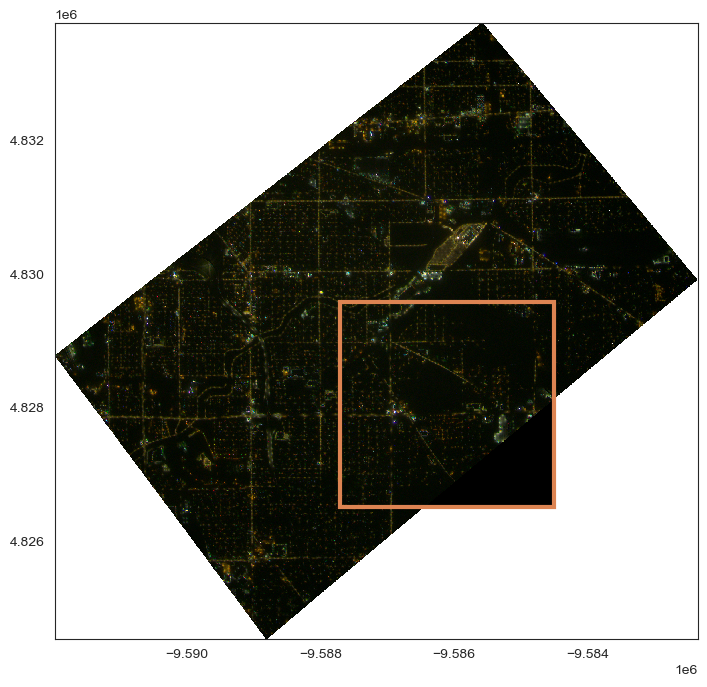

In [22]:
# Compare
fig = plt.figure(figsize=(16,8))
ax = plt.gca()

obs.show(ax=ax, crs='cartesian', img='semitransparent_img')
sub_obs.show(ax=ax, crs='cartesian', img='img')
sub_obs.plot_bounds(ax=ax)

## Determine What Images Are Valid

In [ ]:
metadata['valid'] = True

### Cruise Altitude

In [ ]:
h_max = metadata['mAltitude'].max()
h_min = metadata['mAltitude'].min()
h_diff = h_max - h_min

h_cruising = h_min + settings['percent_for_cruising'] / 100. * h_diff

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(
    metadata['timestamp'],
    metadata['mAltitude'],
)

ax.axhline(h_cruising)

In [ ]:
metadata.loc[metadata['mAltitude']<h_cruising, 'valid'] = False

### Movement

In [ ]:
# Magnitude of Gyro
metadata['imuGyroMag'] = np.sqrt((metadata[['imuGyroX','imuGyroY','imuGyroZ']]**2.).sum(axis='columns'))

In [ ]:
# # Fancy method for movement

# # Select cruise data
# cruise_data = metadata.loc[metadata['flight_phase'] == 'cruise']
# cruise_data = cruise_data.set_index('timestamp')

# # Get rolling deviation
# cruise_rolling = cruise_data.rolling(window=pd.Timedelta(settings['rolling_window_in_min'], 'min'))
# cruise_rolling_std = cruise_rolling.std(numeric_only=True)

# # Identify and store steady data
# cruise_data.loc[:,'is_steady'] = cruise_rolling_std['imuGyroMag'] < settings['mult_of_std_for_steady'] * np.nanmedian(cruise_rolling_std['imuGyroMag'])
# cruise_rolling_std.loc[:,'is_steady'] = cruise_data['is_steady']
# metadata['is_steady'] = False
# metadata.loc[metadata['flight_phase'] == 'cruise','is_steady'] = cruise_data['is_steady'].values

# metadata.loc[~metadata['is_steady'], 'valid'] = False

In [ ]:
# Let's look at the images for a few different movement magnitudes
sorted_by_movement = metadata.loc[metadata['valid']].sort_values('imuGyroMag')

In [ ]:
n_imgs = 3
subplot_mosaic = [[_, ] for _ in range(n_imgs)]
fig = plt.figure(figsize=(15,n_imgs*10))
ax_dict = fig.subplot_mosaic(subplot_mosaic) 

for i in range(n_imgs):
    ax = ax_dict[i]
    
    j = i * len(sorted_by_movement) // n_imgs
    while j < len(sorted_by_movement):
        try:
            ind = sorted_by_movement.index[j]
            obs_i = mm.flight.get_observation(ind)
            obs_i.show(ax=ax)
            break
        except:
            j += 1
    ax.set_title(f"mag = {obs_i.metadata['imuGyroMag']}")

In [ ]:
# Must not be moving too fast
metadata.loc[metadata['imuGyroMag'] > settings['gyro_mag_cut'], 'valid'] = False

### Camera Number

In [ ]:
metadata.loc[metadata['camera_num'] != settings['camera_num'], 'valid'] = False

### Is a Manually-referenced Image

In [ ]:
# metadata.loc[metadata['manually_referenced_fp'].isna(), 'valid'] = False

### Select Data

In [ ]:
selected = metadata.loc[metadata['valid']].copy()
selected.sort_values('timestamp', inplace=True)

# Data split
Only train and test. No validation for right now, but maybe later. Final sample will be using manually referenced ones for validation maybe?

In [ ]:
selected_train, selected_test = sklearn.model_selection.train_test_split(selected, test_size=settings['test_size'], random_state=settings['random_state'])

# Mosaic Creation

## Detect and Blend

### Setup

In [ ]:
# Create OpenCV objects
orb = cv2.ORB_create()
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

In [ ]:
def incorporate_image(obs, dst_image, homography_det_min=settings['homography_det_min'], n_matches_used=-1, verbose=False):
    
    # Perform match
    matches = bf.match(obs.des, dst_image.des)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Points for the transform
    src_pts = np.array([obs.kp[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.array([dst_image.kp[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    # Get the transform
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)
    abs_det_M = np.abs(np.linalg.det(M))
    if verbose:
        print(abs_det_M)
    
    # For bad transforms (e.g. small determinant) return as-is
    if (abs_det_M < homography_det_min) or (abs_det_M > 1./homography_det_min):
        return dst_image, 1

    # Corners for image
    img_height, img_width = obs.img_shape
    corners = np.float32([[0, 0], [0, img_height], [img_width, img_height], [img_width, 0]])
    transformed_corners = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), M)
    
    # Corners for the destination image
    dst_height, dst_width = dst_image.img_shape
    dst_corners = np.float32([[0, 0], [0, dst_height], [dst_width, dst_height], [dst_width, 0]])
    
    # Get dimensions of combined image
    all_corners = np.concatenate([transformed_corners.reshape(-1, 2), dst_corners])
    px_min, py_min = all_corners.min(axis=0).astype('int')
    px_max, py_max = all_corners.max(axis=0).astype('int')
    width = px_max - px_min
    height = py_max - py_min
    
    # Translation matrix to shift the transformed image within the new bounds
    translation_matrix = np.array([[1, 0, -px_min], [0, 1, -py_min], [0, 0, 1]]).astype(float)

    # Update the homography matrix to include the translation
    new_M = np.dot(translation_matrix, M)

    # Warp the image being fit
    warped_img = cv2.warpPerspective(obs.img_int, new_M, (width, height))

    # Translate the dst image
    translated_dst_img = cv2.warpPerspective(dst_image.img_int, translation_matrix, (width, height))

    # Make masks for blending. To start we'll want to just overlay images. We can average later.
    # Overlaying means we only want to add warped image where the translated image does not exist
    dst_img_exists = dst_image.get_nonzero_mask().astype(np.uint8)
    translated_dst_img_exists = cv2.warpPerspective(dst_img_exists, translation_matrix, (width, height))

    # Overlay
    include_warped_img = ~(translated_dst_img_exists.astype(bool))
    blended_img = copy.copy(translated_dst_img)
    blended_img[include_warped_img] = warped_img[include_warped_img]
    
    # Convert bounds
    x_bounds, y_bounds = dst_image.convert_pixel_to_cart(
        np.array([px_min, px_max]),
        np.array([py_max, py_min]),
    )
    
    # Output image
    out_image = observations.ReferencedImage(
        blended_img,
        x_bounds,
        y_bounds,
        cart_crs_code = mm.flight.cart_crs_code,
        latlon_crs_code = mm.flight.latlon_crs_code,
    )
    
    return out_image, 0

### Order of Iteration

In [ ]:
# Determine order for sorting
selected_train.sort_values('timestamp', inplace=True)
indices = selected_train.index

In [ ]:
# Colors
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(indices) - 1)
cmap = sns.color_palette('viridis', as_cmap=True)

In [ ]:
# Plot images, colored by order of overlay
fig = plt.figure(figsize=(15,15))
ax = plt.gca()

# Plot centers
ax.scatter(
    selected_train.loc[indices, 'img_x_center'],
    selected_train.loc[indices, 'img_y_center'],
    color=cmap(norm(np.arange(len(indices)))),
)

# Plot bounds
for i, ind in enumerate(indices):
    row_i = selected_train.loc[ind]

    rect = patches.Rectangle(
        (row_i['img_x_min'], row_i['img_y_min']),
        row_i['img_width'],
        row_i['img_height'],
        linewidth=3,
        facecolor='none',
        edgecolor=cmap(norm(i))
    )
    ax.add_patch(rect)
    
    ax.annotate(
        text=i,
        xy=(row_i['img_x_min'], row_i['img_y_min']),
        xycoords='data',
        xytext=(2, 2),
        textcoords='offset points',
        ha='left',
        va='bottom',
        size = 20,
    )

ax.set_aspect('equal')

### First Two Images

In [ ]:
# Starting image
ind0 = selected_train.loc[selected_train['manually_referenced_fp'].notna()].index[0]
obs0 = mm.flight.get_referenced_observation(ind0)

In [ ]:
# First image to incorporate
ind1 = indices[1]
obs1 = mm.flight.get_observation(ind1)

In [ ]:
# Second image to incorporate
ind2 = indices[2]
obs2 = mm.flight.get_observation(ind2)

In [ ]:
# First incorporated image
dst_img1, return_code1 = incorporate_image(obs1, obs0)
dst_img1_even_if_bad, _ = incorporate_image(obs1, obs0, homography_det_min=1e-12, verbose=True)

In [ ]:
subplot_mosaic = [['obs0', 'obs1'], ['combined', 'combined']]

fig = plt.figure(figsize=(21,14))
ax_dict = fig.subplot_mosaic(subplot_mosaic, height_ratios=[10,20])

# Overplotted expectation
ax = ax_dict['obs0']

# Starting image
obs0.show(ax=ax, crs='cartesian', img='semitransparent_img')
obs0.plot_bounds(ax=ax, edgecolor=palette[0], label='img0', zorder=100, linewidth=7)
ax.set_title('obs0')

# First image
ax = ax_dict['obs1']
obs1.show(ax=ax)
ax.set_title('obs1')

ax = ax_dict['combined']
dst_img1_even_if_bad.show(ax=ax, crs='cartesian', img='semitransparent_img')
ax.set_title(f'Bad = {bool(return_code1)}')

### First Valid Images

In [ ]:
dst_img = obs0
return_code_i = 1
i = 0
while return_code_i != 0:
    i += 1
    ind = indices[i]
    obs_i = mm.flight.get_observation(ind)
    dst_img, return_code_i = incorporate_image(obs_i, dst_img, homography_det_min=1e-1, verbose=True)
obs2 = obs_i
dst_img2 = dst_img

In [ ]:
# Only plot matches
matches = bf.match(obs2.des, dst_img1.des)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
obs2_matched_kps = [obs2.kp[m.queryIdx] for m in matches]
dst_img1_matched_kps = [dst_img1.kp[m.trainIdx] for m in matches]
match_distances = [m.distance for m in matches]

In [ ]:
obs2_kp_pxs, obs2_kp_pys = np.array([_.pt for _ in obs2_matched_kps]).transpose()
dst_img1_kp_pxs, dst_img1_kp_pys = np.array([_.pt for _ in dst_img1_matched_kps]).transpose()
dst_img1_kp_xs, dst_img1_kp_ys = dst_img1.convert_pixel_to_cart(dst_img1_kp_pxs, dst_img1_kp_pys)

In [ ]:
n_shown = 5
subplot_mosaic = [['dst_img1', 'obs2'], ['combined', 'combined']]

fig = plt.figure(figsize=(20,20))
ax_dict = fig.subplot_mosaic(subplot_mosaic)


# First combined image
ax = ax_dict['dst_img1']

dst_img1.show(ax=ax, img='semitransparent_img')
dst_img1.plot_kp(ax=ax, kp=dst_img1_matched_kps[:n_shown], crs_transform=None, colors=match_distances, cmap='viridis_r')

# Next image to add
ax = ax_dict['obs2']

obs2.show(ax=ax)
obs2.plot_kp(ax=ax, kp=obs2_matched_kps[:n_shown], colors=match_distances, cmap='viridis_r')

for i in range(n_shown):

    match = matches[i]
    xy = dst_img1_matched_kps[i].pt
    obs2_xy = obs2_matched_kps[i].pt

    con = patches.ConnectionPatch(
        xyA=xy,
        xyB=obs2_xy,
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['dst_img1'],
        axesB=ax_dict['obs2'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)

# Combined reality
ax = ax_dict['combined']
dst_img2.show(ax=ax, crs='cartesian', img='semitransparent_img')

# Add labels
for ax_key, ax in ax_dict.items():
    ax.set_title(ax_key)

### Larger Loop

In [ ]:
dst_img = obs0
included_indices = []
snapshot_imgs = []
snapshot_frequency = 10
for i, ind in enumerate(tqdm.tqdm(selected_train.index)):
    
    obs_i = mm.flight.get_observation(ind)
    dst_img, return_code_i = incorporate_image(obs_i, dst_img, homography_det_min=0.5)
    
    if return_code_i == 0:
        included_indices.append(ind)
        if len(included_indices) % snapshot_frequency == 0:
            snapshot_imgs.append(copy.copy(dst_img.img_int))
            
    if len(included_indices) > 40:
        break

In [ ]:
subplot_mosaic = [[_,] for _ in range(len(snapshot_imgs))]
fig = plt.figure(figsize=(14, 7*len(subplot_mosaic)))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

for i, snapshot_img in enumerate(snapshot_imgs):
    ax = ax_dict[i]
    
    ax.imshow(snapshot_img)
    
    ax.annotate(
        text=f'# included = {(i+1)*snapshot_frequency}',
        xy=(1, 1),
        xytext=(-5, -5),
        xycoords='axes fraction',
        textcoords='offset points',
        ha='right',
        va='top',
        color='w',
    )
    
    ax.tick_params(labelleft=False, labelbottom=False)
    
plt.tight_layout()

## Blend Referenced Images

### Setup

In [ ]:
referenced = metadata.loc[metadata['manually_referenced_fp'].notna()]

In [ ]:
def blend_referenced_images(src, dst):

    # Bounds
    src_x_bounds, src_y_bounds = src.cart_bounds
    dst_x_bounds, dst_y_bounds = dst.cart_bounds
    x_bounds = [
        min(src_x_bounds[0], dst_x_bounds[0]),
        max(src_x_bounds[1], dst_x_bounds[1])
    ]
    y_bounds = [
        min(src_y_bounds[0], dst_y_bounds[0]),
        max(src_y_bounds[1], dst_y_bounds[1])
    ]

    # Resolution
    dst_xs, dst_ys = dst.get_cart_coordinates()
    dx = dst_xs[1] - dst_xs[0]
    dy = dst_ys[0] - dst_ys[1]

    # New, combined, x coordinates
    pre_xs = np.arange(dst_xs[0], x_bounds[0] - dx, -dx)[::-1][:-1]
    post_xs = np.arange(dst_xs[-1], x_bounds[1] + dx, dx)[1:]
    xs = np.concatenate([
        pre_xs,
        dst_xs,
        post_xs
    ])

    # The original image is contained within xs[dst_x_start_ind:dst_x_stop_ind]
    dst_x_start_ind = pre_xs.size
    dst_x_stop_ind = dst_x_start_ind + dst_xs.size

    # New, combined, y coordinates
    pre_ys = np.arange(dst_ys[0], y_bounds[1] + dy, dy)[::-1][:-1]
    post_ys = np.arange(dst_ys[-1], y_bounds[0] - dy, -dy)[1:]
    ys = np.concatenate([
        pre_ys,
        dst_ys,
        post_ys,
    ])

    # The original image is contained within ys[dst_y_start_ind:dst_y_stop_ind]
    dst_y_start_ind = pre_ys.size
    dst_y_stop_ind = dst_y_start_ind + dst_ys.size

    # Make the blended image and add the original image
    blended_img = np.zeros(shape=(ys.size, xs.size, 3), dtype=dst.img_int.dtype)
    blended_img[dst_y_start_ind:dst_y_stop_ind, dst_x_start_ind:dst_x_stop_ind] = dst.img_int 

    # Get the resized image shape
    is_resized_x = (
        (src_x_bounds[0] <= xs)
        & (xs <= src_x_bounds[1])
    )
    is_resized_y = (
        (src_y_bounds[0] <= ys)
        & (ys <= src_y_bounds[1])
    )
    resized_src_x_inds = np.arange(xs.size)[is_resized_x]
    resized_src_y_inds = np.arange(ys.size)[is_resized_y]

    # Make the padded new image
    src_padded = np.zeros(shape=(ys.size, xs.size, 3), dtype=dst.img_int.dtype)
    src_padded[
        resized_src_y_inds.min():resized_src_y_inds.max() + 1,
        resized_src_x_inds.min():resized_src_x_inds.max() + 1,
        :
    ] = cv2.resize(src.img_int[:,:,:3], (is_resized_x.sum(), is_resized_y.sum()))

    # Finish blending
    is_empty = (blended_img.sum(axis=2) == 0)
    blended_img = np.array([np.where(is_empty, src_padded[:,:,j], blended_img[:,:,j]) for j in range(3)])
    blended_img = blended_img.transpose(1, 2, 0)

    # Store as a referenced image object
    blended = observations.ReferencedImage(
        blended_img,
        x_bounds,
        y_bounds,
    )

    # TEST
    assert (np.diff(ys) > 0).sum() == 0, 'ys dont increase in the right direction'

    # TEST
    np.testing.assert_allclose(xs[:dst_x_start_ind], pre_xs)
    np.testing.assert_allclose(xs[dst_x_start_ind:dst_x_stop_ind], dst_xs)
    np.testing.assert_allclose(xs[dst_x_stop_ind:], post_xs)

    # TEST
    np.testing.assert_allclose(ys[:dst_y_start_ind], pre_ys)
    np.testing.assert_allclose(ys[dst_y_start_ind:dst_y_stop_ind], dst_ys)
    np.testing.assert_allclose(ys[dst_y_stop_ind:], post_ys)
    
    return blended

### First Two Images

In [ ]:
dst = mm.flight.get_referenced_observation(referenced.index[0])

In [ ]:
obs1 = mm.flight.get_referenced_observation(referenced.index[1])

In [ ]:
blended = blend_referenced_images(obs1, dst)

In [ ]:
subplot_mosaic = [['dst', 'obs_i'], ['overplotted', 'combined']]

fig = plt.figure(figsize=(20,20))
ax_dict = fig.subplot_mosaic(subplot_mosaic)


# First image
ax = ax_dict['dst']
dst.show(ax=ax, crs='cartesian', img='semitransparent_img')


# Image to add
ax = ax_dict['obs_i']
obs1.show(ax=ax, crs='cartesian', img='semitransparent_img')


# Overplotted expectation
ax = ax_dict['overplotted']

# Image to add
obs1.show(ax=ax, crs='cartesian', img='semitransparent_img')
obs1.plot_bounds(ax=ax, edgecolor=palette[1], label='obs_i', zorder=100, linewidth=7)

# First image
dst.show(ax=ax, crs='cartesian', img='semitransparent_img')
dst.plot_bounds(ax=ax, edgecolor=palette[0], label='dst', zorder=100, linewidth=7)


# Combined reality
ax = ax_dict['combined']
blended.show(ax=ax, crs='cartesian', img='semitransparent_img')

# Add labels
for ax_key, ax in ax_dict.items():
    ax.set_title(ax_key)
    
plt.tight_layout()

### Full Loop

In [ ]:
dst = mm.flight.get_referenced_observation(referenced.index[0])
for i, ind in enumerate(tqdm.tqdm(referenced.index)):
    # Skip starting image
    if i == 0:
        continue
        
    obs_i = mm.flight.get_referenced_observation(ind)
        
    dst = blend_referenced_images(obs_i, dst)

In [ ]:
# Create map
location = (np.mean(dst.latlon_bounds[1]), np.mean(dst.latlon_bounds[0]))
m = folium.Map(location, zoom_start=13)
dst.add_to_folium_map(m)
# Add widgets
m.add_child(folium.LayerControl())
print('Layer control added.')
m

# Old

Much assumed we were going to use the Stitcher class

## Using Referenced Files Only

In [ ]:
# Starting image
ind0 = selected_train.index[0]
obs0 = mm.flight.get_referenced_observation(ind0)

In [ ]:
# First image to incorporate
ind1 = indices[1]
obs1 = mm.flight.get_observation(ind1)

In [ ]:
# Second image to incorporate
ind2 = indices[2]
obs2 = mm.flight.get_observation(ind2)

In [ ]:
# Set expectations for first merging of images
reffed_lon_bounds, reffed_lat_bounds = obs0.latlon_bounds
location = (np.mean(reffed_lat_bounds), np.mean(reffed_lon_bounds))
m = folium.Map(location, zoom_start=13)

obs0.add_to_folium_map(m, 'img0')
obs1.add_to_folium_map(m, 'img1')
obs2.add_to_folium_map(m, 'img2')

# Add widgets
m.add_child(folium.LayerControl())
print('Layer control added.')

m

In [ ]:
# First incorporated image
dst_img1, M, mask = incorporate_image(ind1, obs0)

In [ ]:
M, np.linalg.det(M), mask.sum() / mask.size

In [ ]:
# Only plot matches
matches = bf.match(obs1.des, obs0.des)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
match_distances = [m.distance for m in matches]

In [ ]:
subplot_mosaic = [['overplotted'], ['combined']]

fig = plt.figure(figsize=(20,20))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

# Overplotted expectation
ax = ax_dict['overplotted']

# Starting image
obs0.show(ax=ax, crs='cartesian', img='semitransparent_img')
obs0.plot_bounds(ax=ax, edgecolor=palette[0], label='img0', zorder=100, linewidth=7)

# First image
obs1.show(ax=ax, crs='cartesian', img='semitransparent_img')
obs1.plot_bounds(ax=ax, edgecolor=palette[1], label='img1', zorder=100, linewidth=7)

ax = ax_dict['combined']
dst_img1.show(ax=ax, crs='cartesian', img='semitransparent_img')

## Next Two Images

In [ ]:
dst_img2, M, mask = incorporate_image(ind2, dst_img1)

In [ ]:
M, np.linalg.det(M), mask.sum() / mask.size

In [ ]:
# Only plot matches
matches = bf.match(obs2.des, dst_img1.des)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
obs2_matched_kps = [obs2.kp[m.queryIdx] for m in matches]
dst_img1_matched_kps = [dst_img1.kp[m.trainIdx] for m in matches]
match_distances = [m.distance for m in matches]

In [ ]:
obs2_kp_pxs, obs2_kp_pys = np.array([_.pt for _ in obs2_matched_kps]).transpose()
obs2_kp_xs, obs2_kp_ys = obs2.convert_pixel_to_cart(obs2_kp_pxs, obs2_kp_pys)
dst_img1_kp_pxs, dst_img1_kp_pys = np.array([_.pt for _ in dst_img1_matched_kps]).transpose()
dst_img1_kp_xs, dst_img1_kp_ys = dst_img1.convert_pixel_to_cart(dst_img1_kp_pxs, dst_img1_kp_pys)

In [ ]:
subplot_mosaic = [['dst_img1', 'obs2'], ['overplotted', 'combined']]

fig = plt.figure(figsize=(20,20))
ax_dict = fig.subplot_mosaic(subplot_mosaic)


# First combined image
ax = ax_dict['dst_img1']

dst_img1.show(ax=ax, crs='cartesian', img='semitransparent_img')
dst_img1.plot_kp(ax=ax, kp=dst_img1_matched_kps)

# Next image to add
ax = ax_dict['obs2']

obs2.show(ax=ax, crs='cartesian', img='semitransparent_img')
obs2.plot_kp(ax=ax, kp=obs2_matched_kps)


# Overplotted expectation
ax = ax_dict['overplotted']

# Second image
obs2.show(ax=ax, crs='cartesian', img='semitransparent_img')
obs2.plot_bounds(ax=ax, edgecolor=palette[1], label='obs2', zorder=100, linewidth=7)

# First combined image
dst_img1.show(ax=ax, crs='cartesian', img='semitransparent_img')
dst_img1.plot_bounds(ax=ax, edgecolor=palette[0], label='dst_img1', zorder=100, linewidth=7)
# s = dst_img1.plot_kp(ax=ax, kp=dst_img1_matched_kps, colors=match_distances)

# Colormap
cmap = sns.color_palette('viridis_r', as_cmap=True)
n_shown = 50
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_shown)
for i, m in enumerate(matches[:n_shown]):
    ax.plot(
        [obs2_kp_xs[i], dst_img1_kp_xs[i]],
        [obs2_kp_ys[i], dst_img1_kp_ys[i]],
        color=cmap(norm(i)),
    )

# Combined reality
ax = ax_dict['combined']
dst_img2.show(ax=ax, crs='cartesian', img='semitransparent_img')

# Add labels
for ax_key, ax in ax_dict.items():
    ax.set_title(ax_key)

## Misc

In [ ]:
def plot_imgs(imgs, inds):
    
    subplot_mosaic = [[_, ] for _ in np.arange(len(imgs))]
    n_row = len(subplot_mosaic)
    n_col = len(subplot_mosaic[0])
    
    fig = plt.figure(figsize=(10*n_col, 10*n_row))
    ax_dict = fig.subplot_mosaic(subplot_mosaic)
    
    for i in np.arange(len(imgs)):
        ax = ax_dict[i]
        
        ax.imshow(imgs[i])
    
    for ax_key, ax in ax_dict.items():
        ax.set_aspect('equal')

## Make Tiles

### Determine Tilesize

In [ ]:
def get_regulated_bins(xs, ys, max_count):
    '''Bins that limit the count to max_count
    '''

    x_bins = int(np.sqrt(settings['n_tiles_guess']))
    y_bins = x_bins

    # Refine until we can hold all in memory
    while True:

        # Initial guess for tiling
        hist2d, x_edges, y_edges = np.histogram2d(
            xs,
            ys,
            (x_bins, y_bins),
        )
        hist_max = hist2d.max()

        if hist_max < max_count:
            break

        # Determine tile size based on max density and number of files allowed in memory
        max_surface_density = hist_max / (x_edges[1] - x_edges[0]) / (y_edges[1] - y_edges[0])
        tile_area = n_files_in_memory / max_surface_density
        tile_length = np.sqrt(tile_area)
        x_bins = np.arange(xs.min(), xs.max() + tile_length, tile_length)
        y_bins = np.arange(ys.min(), ys.max() + tile_length, tile_length)
        
    return x_bins, y_bins

In [ ]:
# Convert to get sensor coords
selected['sensor_x'], selected['sensor_y'] = latlon_to_cart.transform(selected['GPSLat'], selected['GPSLong'])
x_bins, y_bins = get_regulated_bins(selected['sensor_x'], selected['sensor_y'], n_files_in_memory)

In [ ]:
fig = plt.figure(figsize=(16,8))
ax_dict = fig.subplot_mosaic([['scatter', 'hist_guess', 'hist']])

ax = ax_dict['scatter']
ax.scatter(
    selected['sensor_x'],
    selected['sensor_y'],
)

ax = ax_dict['hist_guess']
hist2d_guess, x_edges, y_edges, img_view = ax.hist2d(
    selected['sensor_x'],
    selected['sensor_y'],
    (int(np.sqrt(settings['n_tiles_guess'])), int(np.sqrt(settings['n_tiles_guess']))),
)
plt.colorbar(img_view, ax=ax)

ax = ax_dict['hist']
hist2d, x_edges, y_edges, img_view = ax.hist2d(
    selected['sensor_x'],
    selected['sensor_y'],
    (x_bins, y_bins),
)
plt.colorbar(img_view, ax=ax)

for ax_key, ax in ax_dict.items():
    ax.set_aspect('equal')

## Mosaic Creation

## Start w/ Georeferenced Data

In [ ]:
referenced = selected.loc[selected['manually_referenced_fp'].notna()]

## Nested Grids

In [ ]:
x_bins, y_bins = get_regulated_bins(referenced['sensor_x'], referenced['sensor_y'], n_man_files_in_memory)

In [ ]:
fig = plt.figure()
ax = plt.gca()

counts, x_bins, y_bins, hist_img = ax.hist2d(
    referenced['sensor_x'],
    referenced['sensor_y'],
    (x_bins, y_bins),
)

ax.set_aspect('equal')
plt.colorbar(hist_img, ax=ax)

### Stitching for an Single Bin

In [ ]:
# Upper right bin
i = len(x_bins) - 2
j = 0

In [ ]:
# Set the border width here while experimenting
border_width = 0.5
dx = x_bins[1] - x_bins[0]
dy = y_bins[1] = y_bins[0]
in_x_bounds = (
    (x_bins[i] - border_width * dx <= referenced['sensor_x'])
    & (referenced['sensor_x'] <= x_bins[i+1] + border_width * dx)
)
in_y_bounds = (
    (y_bins[i] - border_width * dy <= referenced['sensor_y'])
    & (referenced['sensor_y'] <= y_bins[i+1] + border_width * dy)
)
bounded = referenced.loc[in_x_bounds & in_y_bounds]

In [ ]:
# Load images
def load_man_img(fp):
    
    # Load the manually-referenced image
    man_img = cv2.imread(fp, cv2.IMREAD_UNCHANGED)
    man_img = man_img[:, :, ::-1] / 2**16 # Formatting
    
    man_img_int = cv2.normalize(man_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return man_img_int
cell_imgs = [load_man_img(fp) for fp in bounded['manually_referenced_fp']]

In [ ]:
# Stitch
stitcher = cv2.Stitcher_create(1)
status, mosaick = stitcher.stitch(cell_imgs)

In [ ]:
# Inspect
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

ax.imshow(
    mosaick
)

Uh oh, defects abound. We'll need to dig into the stitcher...

## Image Pyramids

If we reduce the resolution sufficiently, we can stitch all the images at once, and then iterate from there. Let's calculate what the resolution would be of the new images.

In [ ]:
new_resolution = tuple(np.ceil(np.array(mm.flight.img_shape) / np.sqrt(n_files_in_memory)).astype(np.int32))
print(f'Old resolution = {mm.flight.img_shape}')
print(f'New resolution = {new_resolution}')

It's not clear that downsampling the images this much would work.

## Retrieve Coordinates for Manually-Referenced Images

In [ ]:
def get_bounds(self, dst_crs=latlon_crs):
    
    # Get the coordinates
    x_min, px_width, x_rot, y_max, y_rot, px_height = self.GetGeoTransform()
    x_max = x_min + px_width * dataset.RasterXSize
    y_min = y_max + px_height * dataset.RasterYSize
    
    man_crs = pyproj.CRS(self.GetProjection())
    man_to_dst = pyproj.Transformer.from_crs(man_crs, dst_crs, always_xy=True)
    
    x_bounds, y_bounds = man_to_dst.transform([x_min, x_max], [y_min, y_max])
    
    return (x_bounds, y_bounds)

gdal.Dataset.get_bounds = get_bounds

In [ ]:
man_coords_fp = os.path.join(settings['referenced_dir'], 'img_coordinates_{}.csv'.format(cart_crs.srs.replace(':', '')))

In [ ]:
if os.path.exists(man_coords_fp) and not settings['overwrite_coords_for_reffed']:
    manually_referenced = pd.read_csv(man_coords_fp, index_col=0)
else:
    
    
    calculated = {
        'man_img_x_min': [],
        'man_img_x_max': [],
        'man_img_y_min': [],
        'man_img_y_max': [],
    }

    man_fps = metadata.loc[metadata['manually_referenced_fp'].notna(), 'manually_referenced_fp']
    for i in tqdm.tqdm(range(len(man_fps))):

        man_fp = man_fps.iloc[i]
        ind = man_fps.index[i]
        row = metadata.loc[ind]

        dataset = gdal.Open(man_fp)
        x_lim_man, y_lim_man = dataset.get_bounds(cart_crs)

        calculated['man_img_x_min'].append(x_lim_man[0])
        calculated['man_img_x_max'].append(x_lim_man[1])
        calculated['man_img_y_min'].append(y_lim_man[0])
        calculated['man_img_y_max'].append(y_lim_man[1])

    # Make a dataframe
    manually_referenced = pd.DataFrame(calculated)
    manually_referenced.index = man_fps.index
    manually_referenced['filename'] = metadata['manually_referenced_fp'].str.split('/').str[-1]

    # Save
    manually_referenced.to_csv(man_coords_fp)

In [ ]:
# Manual image centers
manually_referenced['man_x_center'] = 0.5 * (manually_referenced['man_img_x_min'] + manually_referenced['man_img_x_max'])
manually_referenced['man_y_center'] = 0.5 * (manually_referenced['man_img_y_min'] + manually_referenced['man_img_y_max'])

In [ ]:
# Manual image dimensions
manually_referenced['man_img_width'] = manually_referenced['man_img_x_max'] - manually_referenced['man_img_x_min']
manually_referenced['man_img_height'] = manually_referenced['man_img_y_max'] - manually_referenced['man_img_y_min']
manually_referenced['man_img_hypotenuse'] = np.sqrt(manually_referenced['man_img_width']**2. + manually_referenced['man_img_height']**2.)

In [ ]:
metadata = metadata.join(manually_referenced, rsuffix='_man')